In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import interp1d

from glob import glob

import folium

# !pip3 install geopy
from geopy.distance import distance

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# !pip3 install iteround
from iteround import saferound

from collections import Counter

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def pairwise(iterable):
    it = iter(iterable)
    a = next(it, None)
    for b in it:
        yield [a, b]
        a = b
        
def pairwise_list(li, endpoint_unique=False, include_end=False):
    li = list(pairwise(li))
    if include_end:
        for i in range(1,len(li)):
            li[i][0] = li[i][0]+1
    elif endpoint_unique:
        for i in range(0,len(li)-1):
            li[i][1] = li[i][1]-1
    return li


def angleDiff(sourceA,targetA):
    a = targetA - sourceA
    a = (a + 180) % 360 - 180
    return a

def unique_num(x):
    return len(set(x))

def add_degree_to_azimuth(current, change):
    assert(abs(change)<180)
    output = current+change
    if output<-180:
        output = 180-(-output-180)
    elif output>180:
        output = -180+(output-180)
    if output == -180:
        output = -output
    return output
    
import geojson
with open('geoj.geojson') as f:
    gj = geojson.load(f)

# print(gj.keys())
# print(gj['type'],gj['name'],gj['crs'])


In [2]:
length_to_map_zoom_mapping = interp1d([0,100,15000],[20,16,10])

def inspect_street(street_name, return_df = False):
    
    try:

        part = df[df.street_name==street_name]
        part['length'] = part['segment_lengths'].apply(sum)
        street_total_length = part.length.sum()

        street_points_list = part.coordinates.tolist()

        all_streets_center_loc = np.mean([np.mean(li, axis=0).tolist() for li in street_points_list],axis=0)

        my_map = folium.Map(location=all_streets_center_loc,
                                zoom_start= float(length_to_map_zoom_mapping(street_total_length)),
                                tiles="CartoDB dark_matter")

        for street_points in street_points_list:

            folium.PolyLine(street_points, color="red", weight=1).add_to(my_map)

        if return_df:
            return my_map, part

        return my_map

    except:
        
        print('Street Not Found: "'+street_name+'"')

In [3]:
# Get the data for a segment of street from the raw GeoJson file
street_rows = []
for shape in gj['features']:
    properties_temp = shape['properties']
    coordinates = shape['geometry']['coordinates'][0]
    coordinates = np.flip(np.array(coordinates)).tolist()
    properties_temp.update({'coordinates':coordinates})
    street_rows.append(properties_temp)

In [4]:
# Create a pandas dataframe containing the raw data

df = pd.DataFrame(street_rows)

df = df.applymap(lambda x: np.nan if x==None or x=='no name' else x)

df.drop('Shape_Leng',axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   L_f_add      3328 non-null   int64 
 1   L_t_add      3328 non-null   int64 
 2   R_f_add      3328 non-null   int64 
 3   R_t_add      3328 non-null   int64 
 4   Prefix       1229 non-null   object
 5   Pre_type     91 non-null     object
 6   Name         3319 non-null   object
 7   Type         3127 non-null   object
 8   Suffix       1253 non-null   object
 9   Full_name    2875 non-null   object
 10  City         3328 non-null   object
 11  State        3328 non-null   object
 12  coordinates  3328 non-null   object
dtypes: int64(4), object(9)
memory usage: 338.1+ KB


In [6]:
# L_f_add is the building number on the Front of the Left side of this street segment
# R_t_add is the building number on the Tail of the Right side of this street segment
# The first four fields are like these

# Prefix and Suffix are N S E W direction, 
# Pretype and Type are street types,
# Name and type collectively define the address, but sometimes it disagrees with the Full_name
df

,L_f_add,L_t_add,R_f_add,R_t_add,Prefix,Pre_type,Name,Type,Suffix,Full_name,City,State,coordinates
0,9000,9500,9499,9001,NaN,NaN,Depot,Rd,NaN,Park Ter W,New York,New York,"[[40.872716, -73.912379], [40.873421, -73.9128..."
1,9000,9500,9499,9001,NaN,NaN,Prescott,Ave,NaN,Fort George Hill,New York,New York,"[[40.862522, -73.9249], [40.861359, -73.925359..."
2,1,41,2,38,NaN,NaN,Macombs,Pl,NaN,Macombs Pl,New York,New York,"[[40.828028, -73.934515], [40.827728, -73.9357..."
3,1,21,2,20,NaN,NaN,NaN,NaN,NaN,Saint Nicholas Pl,New York,New York,"[[40.834543, -73.938149], [40.833296, -73.9391..."
4,1811,2699,1812,2700,NaN,NaN,8th,Ave,NaN,8th Ave,New York,New York,"[[40.8292, -73.937328], [40.828528, -73.937824..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,0,0,0,0,NaN,NaN,Manhattan Parameter,NaN,NaN,NaN,New York,New York,"[[40.869883, -73.928683], [40.87388, -73.92684..."
3324,0,0,0,0,NaN,NaN,Manhattan Parameter,NaN,NaN,NaN,New York,New York,"[[40.843901, -73.944699], [40.846826, -73.9453..."
3325,0,0,0,0,NaN,NaN,Manhattan Parameter,NaN,NaN,NaN,New York,New York,"[[40.816219, -73.96219], [40.816737, -73.96094..."
3326,0,0,0,0,NaN,NaN,Manhattan Parameter,NaN,NaN,NaN,New York,New York,"[[40.799884, -73.972962], [40.807352, -73.9676..."


In [7]:
raw = df.copy()

In [8]:
# Find the most frequent values for the first four fields, and see their patterns, this is how I guessed the meaning of these fields

top_k = 10
top_starts = pd.concat([df[col].value_counts()[:top_k].reset_index()['index'] for col in df.columns[:4]], axis=1)
top_starts.columns = df.columns[:4]
top_starts

,L_f_add,L_t_add,R_f_add,R_t_add
0,1,0,2,0
1,2,198,1,199
2,0,298,0,299
3,200,398,201,399
4,300,698,301,98
5,135,99,134,699
6,253,19,132,20
7,247,133,248,132
8,131,43,130,18
9,45,251,136,130


### Filter out unreliable entries

In [9]:
df.head()

,L_f_add,L_t_add,R_f_add,R_t_add,Prefix,Pre_type,Name,Type,Suffix,Full_name,City,State,coordinates
0,9000,9500,9499,9001,NaN,NaN,Depot,Rd,NaN,Park Ter W,New York,New York,"[[40.872716, -73.912379], [40.873421, -73.9128..."
1,9000,9500,9499,9001,NaN,NaN,Prescott,Ave,NaN,Fort George Hill,New York,New York,"[[40.862522, -73.9249], [40.861359, -73.925359..."
2,1,41,2,38,NaN,NaN,Macombs,Pl,NaN,Macombs Pl,New York,New York,"[[40.828028, -73.934515], [40.827728, -73.9357..."
3,1,21,2,20,NaN,NaN,NaN,NaN,NaN,Saint Nicholas Pl,New York,New York,"[[40.834543, -73.938149], [40.833296, -73.9391..."
4,1811,2699,1812,2700,NaN,NaN,8th,Ave,NaN,8th Ave,New York,New York,"[[40.8292, -73.937328], [40.828528, -73.937824..."


In [10]:
# Filter out: Building number on the L and R side change in different order/direction
# It's okay if building number grows on both L and R sides, or if building number shrinks on both L and R sides
criteria_1 = ((np.sign(df['L_t_add']-df['L_f_add'])*np.sign(df['R_t_add']-df['R_f_add']))>=0)

# Filter out: All building number start/end is zero
criteria_2 = (df['L_t_add']+df['L_f_add']+df['R_t_add']+df['R_f_add']>0)

# Filter out: Starts and ends of L and R differs too much
criteria_3 = (~((np.abs(df['L_f_add']-df['R_f_add'])>30)|(np.abs(df['L_t_add']-df['R_t_add'])>30))&(df['L_t_add']*df['L_f_add']*df['R_t_add']*df['R_f_add']>0))

df = df[ criteria_1 & criteria_2 & criteria_3 ].reset_index(drop=True)

In [11]:
# (0,0)     (10,10)  (15,15)
# 1/2         4        5/6
# 1-----------4---------6

# 10 = 0 + 4/6*(15-0)

In [12]:
df['min_building_num'] = df[df.columns[:4]].apply(lambda row: min([x for x in row.tolist() if x>0]), axis=1)
df['max_building_num'] = df[df.columns[:4]].apply(lambda row: max([x for x in row.tolist() if x>0]), axis=1)

In [13]:
# 1                   99
# 2        50         100  

# 50/(100-1) ~= 0.5

In [14]:
# 1 3 5 7 9
# 2 4 6 8 10

# 2 4 6 8 10
# 1 3 5 7 9

#         7?
# 1----------10
#         7?

In [15]:
df['odd_on'] = df['L_f_add'].apply(lambda x: 'left' if x%2==1 else 'right')

df.odd_on.value_counts()

left     1841
right    1377
Name: odd_on, dtype: int64

In [16]:
df['Type'] = df[['Pre_type','Type']].apply(lambda row: row['Type'] if not isinstance(row['Pre_type'],str) else row['Pre_type'] if not isinstance(row['Type'],str) or row['Type'] in row['Pre_type'] else row['Type'] if row['Pre_type'] in row['Type'] else row['Pre_type']+' '+row['Type'], axis=1).fillna('').apply(str.strip)

Type_mapping = {'St': 'Street', 'Ave': 'Avenue', 'Pl': 'Place', 'Ln': 'Lane', 'Aly': 'Alley', 'Sq': 'Square', 'Rd': 'Road', 'Park': 'Park', 'Dr': 'Driveway', 'Sl': 'Slip', 'Row': 'Row', 'Ter': 'Terrace', 'Ct': 'Street', 'Wy': 'Way'}

df['Type'] = df['Type'].apply(lambda x: Type_mapping[x] if x in Type_mapping.keys() else x)

Type_mapping_for_full_name = {' St': ' Street', ' Ave': ' Avenue', ' Pl': ' Place', ' Ln': ' Lane', ' Aly': ' Alley', ' Sq': ' Square', ' Rd': ' Road', ' Park': ' Park', ' Dr': ' Driveway', ' Sl': ' Slip', ' Row': ' Row', ' Ter': ' Terrace', ' Ct': ' Street', ' Wy': ' Way'}



In [17]:
def replace_if_endswith(x,dic = Type_mapping_for_full_name):
    if isinstance(x,str):
        for k in Type_mapping_for_full_name.keys():
            if x.endswith(k):
                x = x.replace(k, Type_mapping_for_full_name[k])
                break
    return x

In [18]:
df['Full_name'] = df['Full_name'].apply(replace_if_endswith)

### About Prefix and Suffix

In [19]:
assert(len(df[(df.Prefix.notnull())&(df.Suffix.isnull())])==0)

# There is no case where Prefix is available while Suffix is missing, in other words, Suffix is always the more complete source

# df[(df.Prefix.isnull())&(df.Suffix.notnull())]
pd.concat([df.Prefix.value_counts(),df.Suffix.value_counts()], axis=1)

,Prefix,Suffix
E,619,634
W,574,577
S,9,11
N,5,9


In [20]:
df['street_name_contains_number'] = df['Name'].apply(lambda x: len(re.findall('\d+',x))>0 if isinstance(x,str) else False)

In [21]:
df['Suffix'] = df['Suffix'].fillna('')
df['Type'] = df['Type'].fillna('')

In [22]:
# If Name field is not available, use Full_name
# Else If Street Name contains number, then put direction indicator (NSWE) in the front (E 14th Street), otherwise put it in the end (Washington Park S).

df['street_name'] = df.apply(lambda row: row['Full_name'] if not isinstance(row['Name'],str) else row['Suffix']+' '+row['Name']+' '+row['Type'] if row['street_name_contains_number'] else row['Name']+' '+row['Type']+' '+row['Suffix'] ,axis=1)


In [23]:
# For the streets that building numbers are in opposite orders, reverse the coordinates' order, keep rest the same
# VERY TRICKY, BUT IT WORKS, CONTACT TIM IF YOU ARE INTERESTED

df.loc[df['L_f_add']>df['L_t_add'],'coordinates'] = df.loc[df['L_f_add']>df['L_t_add'],'coordinates'].apply(lambda li: li[::-1])

df = df.drop(['L_f_add', 'L_t_add', 'R_f_add', 'R_t_add', 'Prefix', 'Pre_type','Name', 'Suffix', 'Full_name', 'City', 'State', 'Type'], axis=1)

In [24]:
# Remove blank space at rears

df.street_name = df.street_name.apply(str.strip)

In [25]:
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
# object for calculating distance and direction

In [26]:
# Generate information of a street segment based on coordinates

def process_list_of_points(list_of_points):

    segment_lengths = []
    directions = []
    for i in range(len(list_of_points)-1):
        f_pt = list_of_points[i]
        t_pt = list_of_points[i+1]
        segment_lengths.append(distance(f_pt,t_pt).m)
        directions.append(geod.Inverse(*t_pt, *f_pt)['azi1'])

    returning_segment_lengths = segment_lengths[:]
    returning_directions = directions[:]
    
    segment_lengths = np.array(segment_lengths)
    directions = np.array(directions)
    
    mu,sig = np.median(directions),np.std(directions)
    non_outlier_mask = (directions < mu+2*sig)&(directions > mu-2*sig)
    if sum(non_outlier_mask)>0:
        directions = directions[non_outlier_mask].copy()
        segment_lengths = segment_lengths[non_outlier_mask].copy()
    
    weighted_average_direction = np.average(directions,weights=segment_lengths)

    return returning_segment_lengths,returning_directions,weighted_average_direction

In [27]:
df['segment_lengths'],df['directions'],df['weighted_avg_direction'] = zip(*df['coordinates'].apply(process_list_of_points))

In [28]:
df.head()

,coordinates,min_building_num,max_building_num,odd_on,street_name_contains_number,street_name,segment_lengths,directions,weighted_avg_direction
0,"[[40.828028, -73.934515], [40.827728, -73.9357...",1,41,left,False,Macombs Place,"[108.89218564983435, 103.55946882576252, 87.06...","[72.18448620315594, 62.40266768869246, 53.7141...",57.882481
1,"[[40.834543, -73.938149], [40.833296, -73.9391...",1,21,left,False,Saint Nicholas Place,"[162.984454991304, 155.8498515236607, 183.3296...","[31.825725359198056, 32.47122250803035, 3.3761...",32.141252
2,"[[40.8292, -73.937328], [40.828528, -73.937824...",1811,2700,left,True,8th Avenue,"[85.55422816532439, 80.25758549716801, 78.0432...","[29.276852296929746, 30.29768481931349, 30.100...",28.644518
3,"[[40.831522, -73.935596], [40.8292, -73.937328]]",2701,2962,left,True,8th Avenue,[296.3702709700277],[29.533960143533527],29.533960
4,"[[40.837104, -73.944336], [40.835004, -73.9450...",1,99,left,False,Fort Washington Avenue,"[240.9199465789936, 174.33827802866435]","[14.537258900970478, 4.968036303131128]",10.519803


In [29]:
df = df.sort_values(['street_name','min_building_num']).reset_index(drop=True)

In [30]:
# Some street segments overlap with each other, we remove all street segments that have such conflicts
# Fix min_building_num

non_overlapping_range_df = pd.DataFrame()

for street_name in df.street_name.unique().tolist():
    
    data = df[df.street_name==street_name]

    data['prev_segment_max_building_num'] = data.max_building_num.shift(1)

    data['min_building_num'] = data.apply(lambda row: row['min_building_num'] if np.isnan(row['prev_segment_max_building_num']) else row['min_building_num'] if row['min_building_num']>row['prev_segment_max_building_num'] else row['prev_segment_max_building_num']+1  , axis=1).apply(int)

    data = data.drop('prev_segment_max_building_num',axis=1)
    
    non_overlapping_range_df = non_overlapping_range_df.append(data, ignore_index=True)
    
# print(sum(non_overlapping_range_df.max_building_num > non_overlapping_range_df.min_building_num))
non_overlapping_range_df = non_overlapping_range_df[non_overlapping_range_df.max_building_num > non_overlapping_range_df.min_building_num].reset_index(drop=True)


In [31]:
# # # Now there is no overlapping building num range problem

data = non_overlapping_range_df.copy()

data['building_num_range'] = data[['min_building_num','max_building_num']].apply(lambda row: list(range(row['min_building_num'],row['max_building_num'])),axis=1)

overlapping_range_detection = data.groupby('street_name').agg({'building_num_range':list})

overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(flatten_list)

overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(lambda li: Counter(li))

overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(lambda counter: [k for k, v in counter.items() if v > 1])

overlapping_range_detection['building_num_range'].apply(len).value_counts()

assert(len( overlapping_range_detection['building_num_range'][overlapping_range_detection['building_num_range'].apply(len)>0] )==0) 

# # # Check satisfied

df = non_overlapping_range_df.copy()

In [32]:
df['building_num_range_length'] = df['max_building_num'] - df['min_building_num']

df['max_building_num_end_points'] = (df.segment_lengths.apply(lambda li: np.array(li)/np.sum(li))*df['building_num_range_length']).apply(lambda li: saferound(li, places=0)).apply(lambda li: np.cumsum(li).astype(np.int0))  +  df['min_building_num']

df['building_num_points'] = df.apply(lambda row: [row['min_building_num']] + row['max_building_num_end_points'].tolist(), axis=1)

df = df.drop('max_building_num_end_points',axis=1)

assert(sum(df.building_num_points.apply(len) != df.coordinates.apply(len)) == 0)

In [33]:
# min_building_num, max_building_num:[20, 57]
# building_num_points:[20, 43, 57]

In [34]:
df.head()

,coordinates,min_building_num,max_building_num,odd_on,street_name_contains_number,street_name,segment_lengths,directions,weighted_avg_direction,building_num_range_length,building_num_points
0,"[[40.741073, -74.009227], [40.739952, -74.0094...",1,19,left,True,10th Avenue,[126.19409117595897],[9.43810945747725],9.438109,18,"[1, 19]"
1,"[[40.742288, -74.00832], [40.741552, -74.00891...",20,57,left,True,10th Avenue,"[95.81388840743195, 59.47528887175885]","[31.457163162796054, 26.57332063595985]",29.586666,37,"[20, 43, 57]"
2,"[[40.743584, -74.007424], [40.742928, -74.0078...",58,95,left,True,10th Avenue,"[81.47486454534267, 81.16035980214168]","[26.60454690200066, 28.873100974335063]",27.736630,37,"[58, 77, 95]"
3,"[[40.744144, -74.006944], [40.743584, -74.0074...",96,112,left,True,10th Avenue,[74.23498585714599],[33.10071865635462],33.100719,16,"[96, 112]"
4,"[[40.74472, -74.006528], [40.744144, -74.006944]]",113,128,left,True,10th Avenue,[72.97872054990263],[28.779540322688746],28.779540,15,"[113, 128]"


In [35]:
# For street parts that have more than one segment, the endpoints are not listed in the same order as other parts. 
# For example, the last (or southeast end) of Pike street has two shape segments, and that part's points are listed in reverse order/direction compared to the other street parts. 
# After some exploration, it turns out that we need to reverse the list before using pairwise_list, so as to reflect the order of the longer sequence

df['coordinates_segments'] = df['coordinates'].apply(lambda li: li[::-1]).apply(pairwise_list)

In [36]:
# coordinates:[point1, point2, point3] 
# coordinates_segments:[[point1, point2],   [point2, point3]]

In [37]:
df.head()

,coordinates,min_building_num,max_building_num,odd_on,street_name_contains_number,street_name,segment_lengths,directions,weighted_avg_direction,building_num_range_length,building_num_points,coordinates_segments
0,"[[40.741073, -74.009227], [40.739952, -74.0094...",1,19,left,True,10th Avenue,[126.19409117595897],[9.43810945747725],9.438109,18,"[1, 19]","[[[40.739952, -74.009472], [40.741073, -74.009..."
1,"[[40.742288, -74.00832], [40.741552, -74.00891...",20,57,left,True,10th Avenue,"[95.81388840743195, 59.47528887175885]","[31.457163162796054, 26.57332063595985]",29.586666,37,"[20, 43, 57]","[[[40.741073, -74.009227], [40.741552, -74.008..."
2,"[[40.743584, -74.007424], [40.742928, -74.0078...",58,95,left,True,10th Avenue,"[81.47486454534267, 81.16035980214168]","[26.60454690200066, 28.873100974335063]",27.736630,37,"[58, 77, 95]","[[[40.742288, -74.00832], [40.742928, -74.0078..."
3,"[[40.744144, -74.006944], [40.743584, -74.0074...",96,112,left,True,10th Avenue,[74.23498585714599],[33.10071865635462],33.100719,16,"[96, 112]","[[[40.743584, -74.007424], [40.744144, -74.006..."
4,"[[40.74472, -74.006528], [40.744144, -74.006944]]",113,128,left,True,10th Avenue,[72.97872054990263],[28.779540322688746],28.779540,15,"[113, 128]","[[[40.744144, -74.006944], [40.74472, -74.0065..."


In [38]:
df['building_num_segments'] = df['building_num_points'].apply(lambda li: pairwise_list(li, endpoint_unique=True, include_end=True))

In [39]:
# building_num_points:[20, 43, 57] 
# building_num_segments:[[20, 43],   [44, 57]]

In [40]:
df.head()

,coordinates,min_building_num,max_building_num,odd_on,street_name_contains_number,street_name,segment_lengths,directions,weighted_avg_direction,building_num_range_length,building_num_points,coordinates_segments,building_num_segments
0,"[[40.741073, -74.009227], [40.739952, -74.0094...",1,19,left,True,10th Avenue,[126.19409117595897],[9.43810945747725],9.438109,18,"[1, 19]","[[[40.739952, -74.009472], [40.741073, -74.009...","[[1, 19]]"
1,"[[40.742288, -74.00832], [40.741552, -74.00891...",20,57,left,True,10th Avenue,"[95.81388840743195, 59.47528887175885]","[31.457163162796054, 26.57332063595985]",29.586666,37,"[20, 43, 57]","[[[40.741073, -74.009227], [40.741552, -74.008...","[[20, 43], [44, 57]]"
2,"[[40.743584, -74.007424], [40.742928, -74.0078...",58,95,left,True,10th Avenue,"[81.47486454534267, 81.16035980214168]","[26.60454690200066, 28.873100974335063]",27.736630,37,"[58, 77, 95]","[[[40.742288, -74.00832], [40.742928, -74.0078...","[[58, 77], [78, 95]]"
3,"[[40.744144, -74.006944], [40.743584, -74.0074...",96,112,left,True,10th Avenue,[74.23498585714599],[33.10071865635462],33.100719,16,"[96, 112]","[[[40.743584, -74.007424], [40.744144, -74.006...","[[96, 112]]"
4,"[[40.74472, -74.006528], [40.744144, -74.006944]]",113,128,left,True,10th Avenue,[72.97872054990263],[28.779540322688746],28.779540,15,"[113, 128]","[[[40.744144, -74.006944], [40.74472, -74.0065...","[[113, 128]]"


In [41]:
full = pd.DataFrame(zip(np.repeat(  df.street_name.values, df['coordinates_segments'].apply(len)  ),
np.repeat(  df.odd_on.values, df['coordinates_segments'].apply(len)  ),
np.repeat(  df.weighted_avg_direction.values, df['coordinates_segments'].apply(len)  ),
flatten_list((df.building_num_segments.tolist())),
flatten_list(df.coordinates_segments.tolist()),
flatten_list((df.segment_lengths.tolist())),
flatten_list((df.directions.tolist()))), columns = ['street_name','odd_on','avg_direction','building_num_range','start_end_coordinates','segment_length','segment_direction'])

In [42]:
full['building_num_range_length'] = full['building_num_range'].apply(lambda x: x[1]-x[0]+1)
# print(sum(full['building_num_range_length']<=0))

full = full[full['building_num_range_length']>0].reset_index(drop=True)

full['avg_length_per_building'] = full['segment_length']/full['building_num_range_length']

full['direction_deviation'] = full[['segment_direction','avg_direction']].apply(lambda row: angleDiff(row['segment_direction'],row['avg_direction']),axis=1)

The buildings on the 99% of the streets occupy fewer than 31 meters.


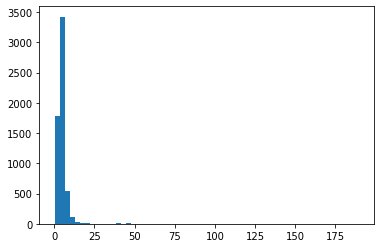

In [43]:
# -------------------100m------------------#
#  H       H    H           H        H     #
# On average, each House occupies 100/5=20 meters

plt.hist(full.avg_length_per_building,bins=60)
avg_length_per_building_thres = np.percentile(full.avg_length_per_building,99)
print(f'The buildings on the 99% of the streets occupy fewer than {avg_length_per_building_thres:.0f} meters.')

In [44]:
# Remove houses that are 3 times as wise as the 99% threshold
full = full[full.avg_length_per_building<avg_length_per_building_thres * 3].reset_index(drop=True)

In [45]:
# Different segments of a street should put odd building numbers on the same side
# For the anomaly, we inspect them and decide how to fix them

left_right_inconsistent_correction = full.groupby('street_name').agg({'odd_on':Counter})['odd_on'][full.groupby('street_name').agg({'odd_on':Counter})['odd_on'].apply(len)>1]
left_right_inconsistent_correction.reset_index()

,street_name,odd_on
0,1st Avenue,"{'left': 124, 'right': 1}"
1,4th Avenue,"{'right': 101, 'left': 13}"
2,6th Avenue,"{'left': 85, 'right': 2}"
3,7th Avenue,"{'right': 64, 'left': 25}"
4,B Avenue,"{'right': 19, 'left': 3}"
5,Front Street,"{'right': 18, 'left': 4}"
6,Gramercy Park,"{'left': 6, 'right': 2}"
7,W 47th Street,"{'right': 6, 'left': 1}"
8,W 58th Street,"{'right': 6, 'left': 2}"


In [46]:
# If one kind of labels are ten times as many as the other one, we think the other label is a mistake in entry or our preprocessing
# by this criteria, we will set "1st Avenue" to be all left, "6th Avenue" to be all left.

full.loc[(full.street_name=='1st Avenue') | (full.street_name=='6th Avenue'), 'odd_on'] = 'left'

In [47]:
#-------------------------------------------------------------#
    # distance from center to one side = 5 meters
# Street

#-------------------------------------------------------------#




#-------------------------------------------------------------#

    # distance from center to one side = 10 meters

# Avenue



#-------------------------------------------------------------#



# Once we know the location of center of the street, then SHIFT
#      --- to the right or the left (depending on "odd_on" and the building number's odd/even status)
#      --- by ? meters depending which type of road it is


valid_road_type = {'Way', 'Street', 'Driveway', 'River', 'Square', 'Place', 'Front', 'Terrace', 'Slip', 'Island', 'Row', 'Alley', 'Road', 'Pier', 'Lane', 'Broadway', 'Park', 'Avenue'}

full['road_type'] = full.street_name.apply(lambda x: re.sub('\s+[N|E|S|W]$','',re.sub('\s+\d+','',x))).apply(lambda x: x.split()[-1] if x.split()[-1] in valid_road_type else 'Generic')

full['offset_from_road_center'] = full['road_type'].apply(lambda x: 10 if x in ['Avenue','Broadway'] else 5)

In [48]:
full.street_name = full.street_name.apply(lambda x: ' '.join(x.strip().split()))

# Fix after manual inspection
full.street_name = full.street_name.apply(lambda x: 'East Broadway' if x=='Broadway E' else 'West Broadway' if x=='Broadway W' else x)


In [49]:
streets = full.street_name.drop_duplicates().tolist()

In [50]:
# Voila!
# full.to_csv('_1880_streets_full.csv',index=False)

In [51]:
### Visualization # FOLIUM

colors = ['red','orange','green','blue','purple']

center_loc = np.mean(flatten_list(full.start_end_coordinates.tolist()),axis=0).tolist()

my_map = folium.Map(location=center_loc,zoom_start= 13,tiles="CartoDB dark_matter")


# [ '6th Avenue', '7th Avenue']
# [s for s in full.street_name.drop_duplicates().tolist() if s.endswith(' Avenue')]

for i in range(len(streets)):
    
    street_name = streets[i]
    
    street_points = flatten_list(full[full.street_name == street_name].start_end_coordinates.tolist())

    folium.PolyLine(street_points, color=colors[i%len(colors)], weight=1).add_to(my_map)
    
#     for pt in street_points:
#         folium.Marker(location=pt,popup='%f, %f' % tuple(pt)).add_to(my_map)

# del my_map

## Start geocoding

In [52]:
#geo = pd.read_csv('Geoloaded_1910_New York_Manhattan Ward 7.csv')

#geo = geo[['RecordId','Street Name','House Number','Street Name New','House Number New','Address','Lat','Lon','Enumeration District Number','Ward of City']]

#geo['Street Name New'] = geo['Street Name New'].apply(lambda x: 'Rutgers Street' if x.startswith('Rutgers') else x)

#geo = geo.drop_duplicates(subset=geo.columns[1:].tolist(), keep='last')[geo.columns[1:]].reset_index()

#geo['Number of Residents'] = geo['index'].diff().fillna(geo['index'][0]).apply(int)

#geo = geo.drop('index',axis=1)

In [53]:
geo = pd.read_csv('cleaned/1898_address_CLEANED.csv')

geo = geo[['street_clean', 'num_clean']]

#geo = geo.drop_duplicates(subset=geo.columns[0:].tolist(), keep='last')[geo.columns[1:]].reset_index()

#geo = geo.drop('index',axis=1)

In [54]:
geo['addresses'] = geo['street_clean']+ ' ' + geo['num_clean'].dropna().astype(int).astype(str)
geo.head()

,street_clean,num_clean,addresses
0,W 39th Street,548.0,W 39th Street 548
1,Eldridge Street,113.0,Eldridge Street 113
2,6th Avenue,486.0,6th Avenue 486
3,Cherry Street,292.0,Cherry Street 292
4,Allen Street,155.0,Allen Street 155


In [55]:
#print(', '.join(sorted(geo['street_clean'].dropna().drop_duplicates().tolist())))

In [56]:
print(f"{np.mean(geo['street_clean'].isin(streets))*100:.1f}% of the streets in geo are covered in our 1880 address database.")

94.4% of the streets in geo are covered in our 1880 address database.


In [57]:
addresses = sorted(geo['addresses'].dropna().drop_duplicates().tolist())

In [58]:
def get_coordinates_from_details(target_building_num,building_num_range,start_end_coordinates,segment_direction,odd_on,offset_from_road_center):
    
    is_odd = target_building_num%2==1
    
    if (building_num_range[1] - building_num_range[0])==0:
        street_center_position = np.mean(start_end_coordinates,axis=0).tolist()
    else:
        f_pt_proportion = (target_building_num - building_num_range[0])/(building_num_range[1] - building_num_range[0])
        t_pt_proportion = 1 - f_pt_proportion
        street_center_position = np.average(np.array(start_end_coordinates), weights = (f_pt_proportion,t_pt_proportion), axis=0).tolist()

    offset_direction = add_degree_to_azimuth(segment_direction,-90) if ((odd_on=='left' and is_odd) or (odd_on=='right' and not is_odd))  else add_degree_to_azimuth(segment_direction,90)

    target_position = geod.Direct(*street_center_position, offset_direction, offset_from_road_center)
    target_point = list([target_position['lat2'],target_position['lon2']])

    return target_point

def get_addr_coordinates(addr):
    target_street_name, target_building_num = ' '.join(addr.split()[:-1]), addr.split()[-1]
    target_building_num = int(target_building_num)
    matched = full[full.street_name==target_street_name].copy().apply(lambda row: get_coordinates_from_details(target_building_num, row['building_num_range'],row['start_end_coordinates'],row['segment_direction'],row['odd_on'],row['offset_from_road_center']) if target_building_num>= row['building_num_range'][0] and target_building_num <= row['building_num_range'][1] else np.nan, axis=1).dropna()
    if len(matched)>0:
        return tuple(matched.tolist()[0])
    return (np.nan,np.nan)

In [59]:
addresses_coordinates = []
for addr in addresses:
    #try:
    addresses_coordinates.append(get_addr_coordinates(addr))
    #except ValueError:
    #    addresses_coordinates.append((np.nan,np.nan))

addr_to_coordinates = pd.DataFrame(zip(addresses,addresses_coordinates),columns=['addresses','Coordinates'])

new_geo = pd.merge(geo,addr_to_coordinates)
new_geo['Lat'],new_geo['Lon'] = zip(*new_geo['Coordinates'])

print()
print(f"{np.round(new_geo['Lat'].isnull().sum()/len(new_geo),3)*100:.1f}% of the address are not found.")
print(f"{(new_geo.drop_duplicates(subset=['addresses'])['Lat'].value_counts()[new_geo.drop_duplicates(subset=['addresses'])['Lat'].value_counts()>1].sum()/len(geo.drop_duplicates(subset=['addresses'])))*100:.1f}% of the addresses have the same coordinate with somewhere else.\n")

geo_info_df = new_geo[['addresses','Lat','Lon']].dropna().drop_duplicates()


8.2% of the address are not found.
0.1% of the addresses have the same coordinate with somewhere else.



In [60]:
geo_info_df

,addresses,Lat,Lon
0,W 39th Street 548,40.759086,-74.000564
1,Eldridge Street 113,40.719779,-73.991424
2,6th Avenue 486,40.747416,-73.989780
4,Cherry Street 292,40.712108,-73.987092
5,Allen Street 155,40.721832,-73.989491
...,...,...,...
1972,Sheriff Street 96,40.718515,-73.981046
1973,Pearl Street 32,40.703109,-74.012892
1974,8th Avenue 2597,40.828275,-73.938156
1975,Bleecker Street 120,40.727935,-73.997703


In [61]:
geo_info_df.to_csv('geocoded/1898_address_geocoded.csv')

#### Older version

In [62]:
#def get_coordinates_from_details(target_building_num,building_num_range,start_end_coordinates,segment_direction,odd_on,offset_from_road_center):
    
#    is_odd = target_building_num%2==1
    
#    if (building_num_range[1] - building_num_range[0])==0:
#        street_center_position = np.mean(start_end_coordinates,axis=0).tolist()
#    else:
#        f_pt_proportion = (target_building_num - building_num_range[0])/(building_num_range[1] - building_num_range[0])
#        t_pt_proportion = 1 - f_pt_proportion
#        street_center_position = np.average(np.array(start_end_coordinates), weights = (f_pt_proportion,t_pt_proportion), axis=0).tolist()

#    offset_direction = add_degree_to_azimuth(segment_direction,-90) if ((odd_on=='left' and is_odd) or (odd_on=='right' and not is_odd))  else add_degree_to_azimuth(segment_direction,90)

#    target_position = geod.Direct(*street_center_position, offset_direction, offset_from_road_center)
#    target_point = list([target_position['lat2'],target_position['lon2']])

#    return target_point

In [63]:
# Given an address, first choose the relevant data based on street name
# Then find which segment of the street is relevant baesd on the building number
# After that, calculate the proportional location based on the building number and the start and end building numbers of the segment
# Calculate the geolocation of the center of street at that location
# Shift the location to one side by a proper distance
# Return the final coordinates

#def get_addr_coordinates(addr):
#    target_street_name, target_building_num = ' '.join(addr.split()[:-1]), addr.split()[-1]
#    target_building_num = int(target_building_num)
#    matched = full[full.street_name==target_street_name].copy().apply(lambda row: get_coordinates_from_details(target_building_num, row['building_num_range'],row['start_end_coordinates'],row['segment_direction'],row['odd_on'],row['offset_from_road_center']) if target_building_num>= row['building_num_range'][0] and target_building_num <= row['building_num_range'][1] else np.nan, axis=1).dropna()
#    if len(matched)>0:
#        return tuple(matched.tolist()[0])
#    return (np.nan,np.nan)

In [64]:
#addresses_coordinates = []
#for addr in addresses:
#    try:
#        addresses_coordinates.append(get_addr_coordinates(addr))
#    except ValueError:
#        pass

#addr_to_coordinates = pd.DataFrame(zip(addresses,addresses_coordinates),columns=['Address','Coordinates'])

In [65]:
#new_geo = pd.merge(geo,addr_to_coordinates)

#new_geo = new_geo.rename(columns = {'Lat':'API Lat','Lon':'API Lon'})

#new_geo['GIS Lat'],new_geo['GIS Lon'] = zip(*new_geo['Coordinates'])

In [66]:
#print(f"\nPreviously, {(new_geo.drop_duplicates(subset=['Address'])['API Lat'].value_counts()[new_geo.drop_duplicates(subset=['Address'])['API Lat'].value_counts()>1].sum()/len(geo.drop_duplicates(subset=['Address'])))*100:.1f}% of the addresses have the same API lat,lon coordinate with somewhere else.\n")
#print(f"In comparison, {(new_geo.drop_duplicates(subset=['Address'])['GIS Lat'].value_counts()[new_geo.drop_duplicates(subset=['Address'])['GIS Lat'].value_counts()>1].sum()/len(geo.drop_duplicates(subset=['Address'])))*100:.1f}% of the addresses have the same GIS lat,lon coordinate with somewhere else.\n")
#print(f"In terms of coverage, the API method has {new_geo['API Lat'].isnull().mean()*100:.01f}% missing values, while the GIS method has {new_geo['GIS Lat'].isnull().mean()*100:.01f}% missing values.\n")

In [67]:
#valid_new_geo = new_geo[new_geo.Coordinates!=(np.nan,np.nan)].copy()

#max_num_of_res = valid_new_geo['Number of Residents'].max()

#list_of_points = valid_new_geo.Coordinates.tolist()

#residents_at_points = valid_new_geo['Number of Residents'].tolist()

#max_r = (0.5+np.log(max(residents_at_points))**1.2)

#center_loc = np.mean( list_of_points ,axis=0).tolist()

#my_map = folium.Map(location=center_loc,zoom_start=15)# ,tiles="CartoDB dark_matter")


#plot_streets = valid_new_geo['Street Name New'].drop_duplicates().tolist()
#for s in plot_streets:

#    line_weight = 8 if s.endswith('Avenue') or s.endswith('Broadway') else 5
#    street_points = full[full.street_name==s].start_end_coordinates.tolist()
#    folium.PolyLine(street_points, color='dimgrey', weight=line_weight, alpha = 0.1, popup=s).add_to(my_map)
    

#for i in range(len(list_of_points)):
    
#    pt = list_of_points[i]
#    num_of_res = residents_at_points[i]
        
#    r = 0.5+np.log(num_of_res)**1.2
    
#    color_ratio = r/max_r
#    rgb_tuple = (int(255/2 + 255/2*color_ratio),int(0),int(255/2 - 255/2*color_ratio))
#    hex_code = '#%02x%02x%02x' % rgb_tuple
    
#    folium.Circle(location=pt,radius=r,color=hex_code,alpha=0.3 ).add_to(my_map)
    


#my_map

In [68]:
#my_map.save('demo.html')

#### Point order problem

In [69]:
# this_street = '10th Avenue'
# full[full.street_name==this_street]

In [70]:
# full[full.street_name==this_street]['start_end_coordinates'].apply(lambda li: li[0][0]).plot()

In [71]:
# full[full.street_name==this_street]['start_end_coordinates'].apply(lambda li: li[0][1]).plot()

In [72]:
# full[full.street_name==this_street].segment_direction.plot()

In [73]:
# street_points_list = full[full.street_name==this_street].start_end_coordinates.tolist() 

# ### Visual inspect

# colors = ['red','orange','green','blue','purple','white','brown']

# my_map = folium.Map(location=np.mean(flatten_list(street_points_list),axis=0).tolist(),
#                         zoom_start= 17 ,
#                         tiles="CartoDB dark_matter")

# for i in range(len(street_points_list)):
#     street_points = street_points_list[i]
#     # print(i,street_points)
#     folium.PolyLine(street_points, color=colors[i%len(colors)], weight=(1+i%len(colors))).add_to(my_map)

# #[[40.710512, -73.992112], [40.710864, -73.99232], [40.711312, -73.992416]]
    
# my_map

In [74]:
# street_points_list = raw[raw['Name']==this_street.split()[0]].sort_values('L_f_add').reset_index(drop=True).coordinates.tolist()


# ### Visual inspect

# center = np.mean(flatten_list(street_points_list),axis=0).tolist()

# colors = ['red','orange','green','blue','purple','white','brown']

# my_map = folium.Map(location=center,
#                         zoom_start= 17 ,
#                         tiles="CartoDB dark_matter")

# for i in range(len(street_points_list)):
#     street_points = street_points_list[i]
#     # print(i,street_points)
#     folium.PolyLine(street_points, color=colors[i%len(colors)], weight=(1+i%len(colors))).add_to(my_map)

# my_map

**END** Point order problem <br><br><br><br><br>

#### Old Geo

In [75]:
## old_geo = pd.read_csv('/Users/timsmac/Desktop/us_census_data/aggregate/Geoloaded_1910_New York_Manhattan Ward 7.csv')

## old_geo = old_geo[['Street Name','House Number','Street Name New', 'House Number New', 'Address', 'Lon', 'Lat', 'Enumeration District Number', 'Ward of City']]

## old_geo = old_geo.drop_duplicates(['Street Name','House Number'])

## old_geo.to_csv('_old_geo_for_comparison.csv',index=False)

**END** Old Geo<br><br><br><br><br>

In [76]:
# li = [street_center_position,target_point]

# my_map = folium.Map(location=np.mean(li,axis=0).tolist(), zoom_start= 20, tiles="CartoDB dark_matter")

# for i in range(len(li)):
#     pt = li[i]
#     folium.Circle(pt, radius=2,color=colors[i%len(colors)]).add_to(my_map)
    
# my_map

In [77]:
# # # Check and verify that there is overlapping building num range problem

# data = df.copy()

# data['building_num_range'] = df[['min_building_num','max_building_num']].apply(lambda row: list(range(row['min_building_num'],row['max_building_num'])),axis=1)

# overlapping_range_detection = data.groupby('street_name').agg({'building_num_range':list})

# overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(flatten_list)

# overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(lambda li: Counter(li))

# overlapping_range_detection['building_num_range'] = overlapping_range_detection['building_num_range'].apply(lambda counter: [k for k, v in counter.items() if v > 1])

# overlapping_range_detection['building_num_range'].apply(len).value_counts()

# overlapping_range_detection['building_num_range'][overlapping_range_detection['building_num_range'].apply(len)>0][:100]

In [78]:
# # # Fix max_building_num

# non_overlapping_range_df = pd.DataFrame()

# for street_name in df.street_name.unique().tolist():
    
#     data = df[df.street_name==street_name]

#     data['next_segment_min_building_num'] = data.min_building_num.shift(-1)

#     data['max_building_num'] = data.apply(lambda row: row['max_building_num'] if np.isnan(row['next_segment_min_building_num']) else row['max_building_num'] if row['max_building_num']<row['next_segment_min_building_num'] else row['next_segment_min_building_num']-1  , axis=1).apply(int)

#     data = data.drop('next_segment_min_building_num',axis=1)
    
#     non_overlapping_range_df = non_overlapping_range_df.append(data, ignore_index=True)
    

In [79]:
# ### Visual inspect

# street_points_list = df.coordinates.tolist()

# all_streets_center_loc = np.mean([np.mean(li, axis=0).tolist() for li in street_points_list],axis=0)

# my_map = folium.Map(location=all_streets_center_loc,
#                         zoom_start= 13 ,
#                         tiles="CartoDB dark_matter")

# for street_points in street_points_list:

#     folium.PolyLine(street_points, color="red", weight=1).add_to(my_map)

# my_map

In [80]:
# glob('1910MAN/*')

# df = pd.read_csv('1910MAN/1910MANstCLN_W7.csv')

# geo_relevant_cols = ['DataID', 'RecordId', 'HouseHoldId', 'Street Name', 'St_MOD',
#        'ADDY_CLN', 'ZIP', 'City', 'State', 'Country', 'House Number', 'HoNo_1',
#        'Dwelling Number','Enumeration District Number', 'Ward of City']

# df = df[geo_relevant_cols]

# df.ZIP.value_counts()

# df.RecordId.nunique()

# found = pd.read_csv('1910MAN/1910MANstCLN_W7_found.csv')[['RecordId','Longitude', 'Latitude', 'Side']]

# found

# found.Side.value_counts()

# fdf = df[df.RecordId.isin( set(found.RecordId.tolist()) )]

# fdf['House Number'].value_counts()

# fdf.St_MOD.value_counts()

# ndf = df[~df.RecordId.isin( set(found.RecordId.tolist()) )]

# ndf['House Number'].value_counts()

# ndf.St_MOD.value_counts()

In [81]:
# address = 'Macombs Place 16'

# street_name = ' '.join(address.split()[:-1])
# building_number = address.split()[-1]

# # np.cumsum(segment_lengths)